In [8]:
import torch
from torch import nn, optim
from torchvision import models, transforms
from torch.utils.data import DataLoader

from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 as cv
from tqdm import tqdm

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset Inspection

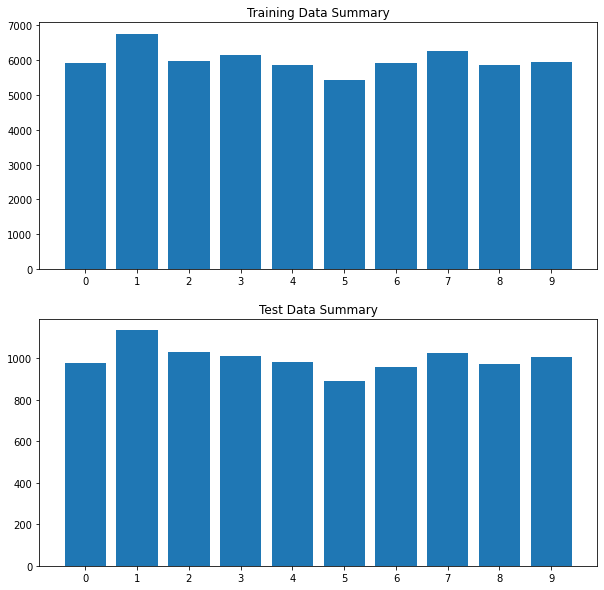

Total Training Data: 60000
Total Test Data: 10000


In [10]:
training_data_folders = os.listdir("dataset/training")
test_data_folders = os.listdir("dataset/testing")
training_data_count = []
test_data_count = []

for folder in training_data_folders:
    folder_count = len(os.listdir(f"dataset/training/{folder}"))
    training_data_count.append(folder_count)

for folder in test_data_folders:
    folder_count = len(os.listdir(f"dataset/testing/{folder}"))
    test_data_count.append(folder_count)

figure = plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.title("Training Data Summary")
plt.bar(training_data_folders, training_data_count)

plt.subplot(2,1,2)
plt.title("Test Data Summary")
plt.bar(test_data_folders, test_data_count)

plt.show()

print(f"Total Training Data: {sum(training_data_count)}")
print(f"Total Test Data: {sum(test_data_count)}")

## Data Loading

In [11]:
data = []

for folder in training_data_folders:
    image_list = os.listdir(f"dataset/training/{folder}")
    for image in image_list:
        temp_arr = [image, folder, "train"]
        data.append(temp_arr)

for folder in test_data_folders:
    image_list = os.listdir(f"dataset/testing/{folder}")
    for image in image_list:
        temp_arr = [image, folder, "test"]
        data.append(temp_arr)

df = pd.DataFrame(data, columns=["file_name", "label", "data_type"])
display(df.head())
display(df.tail())
df.to_csv("annotations.csv", index=False, header=True)

,file_name,label,data_type
0,1.jpg,0,train
1,1000.jpg,0,train
2,10005.jpg,0,train
3,10010.jpg,0,train
4,10022.jpg,0,train


,file_name,label,data_type
69995,9932.jpg,9,test
69996,9945.jpg,9,test
69997,9973.jpg,9,test
69998,999.jpg,9,test
69999,9992.jpg,9,test


## Custom PyTorch Dataset Creation

In [17]:
class mnistDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotations_file, train=True, transform=None, target_transform=None):
        self.root = root
        self.labels = pd.read_csv(annotations_file)
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        if self.train:
            self.root = os.path.join(self.root, "training")
            self.labels = self.labels[self.labels["data_type"] == "train"]
        else:
            self.root = os.path.join(self.root, "testing")
            self.labels = self.labels[self.labels["data_type"] == "test"]
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.root, str(self.labels.iloc[index, 1]), self.labels.iloc[index, 0])
        image = Image.open(image_path).convert("RGB")
        label = self.labels.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
        
composed_transform = transforms.Compose([
    transforms.ToTensor()
])

training_dataset = mnistDataset("dataset", "annotations.csv", train=True, transform=composed_transform, target_transform=None)
test_dataset = mnistDataset("dataset", "annotations.csv", train=False, transform=composed_transform, target_transform=None)

train_loader = DataLoader(dataset=training_dataset, batch_size=32)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

print(training_dataset.__getitem__(0))
print(training_dataset.__len__())

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 1)
60000


## Model Finetuning

In [13]:
model = models.resnet18(pretrained=True)

# Freeze the weights for the layers.
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
# Change the final fully connected layer.
# Note that when creating a new layer, requires_grad is automatically true and gradients are computed.
custom_output_layer = nn.Sequential(
    nn.Linear(num_features, 10),
    nn.Softmax()
)
model.fc = nn.Linear(num_features, 10)
# model.fc = custom_output_layer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model Training

In [14]:
def train_loop(epoch, train_loader, model, loss_function, optimizer):
    model.train()

    batch_size = len(train_loader)
    training_size = len(train_loader.dataset)
    training_loss = 0
    correct = 0

    with tqdm(train_loader, position=0, leave=True, unit="batch") as train_batch:
        train_batch.set_description(f"Epoch: {epoch} --------------------")
        for data in train_batch:
            # Compute prediction and loss
            inputs, labels = data
            predictions = model(inputs)
            loss = loss_function(predictions, labels)
            training_loss += loss.item()

            _, predicted_labels = predictions.max(1)
            correct += predicted_labels.eq(labels).sum().item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    train_accuracy = correct / training_size
    average_train_loss = training_loss / batch_size

    print(f"Train Loss: {round(average_train_loss, 3)}  |   Train Accuracy: {round(train_accuracy, 3)}")

    return average_train_loss, train_accuracy


def test_loop(epoch, test_loader, model, loss_function):
    model.eval()

    batch_size = len(test_loader)
    test_size = len(test_loader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            test_loss += loss_function(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    average_test_loss = test_loss / batch_size
    test_accuracy = correct / test_size

    print(f"Test Loss: {round(average_test_loss, 3)}    |   Test Accuracy: {round(test_accuracy, 3)}")

    return average_test_loss, test_accuracy

train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

epochs = 5
for epoch in range(1, epochs+1):
    average_train_loss, train_accuracy = train_loop(epoch, train_loader, model, loss_function, optimizer)
    average_test_loss, test_accuracy = test_loop(epoch, test_loader, model, loss_function)

    train_loss_list.append(average_train_loss)
    test_loss_list.append(average_test_loss)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)

Epoch: 1 --------------------: 100%|██████████| 1875/1875 [03:29<00:00,  8.96batch/s]


Train Loss: 4.367  |   Train Accuracy: 0.942
Test Loss: 187.621    |   Test Accuracy: 0.101


Epoch: 2 --------------------: 100%|██████████| 1875/1875 [02:17<00:00, 13.69batch/s]


Train Loss: 8.936  |   Train Accuracy: 0.912
Test Loss: 162.946    |   Test Accuracy: 0.101


Epoch: 3 --------------------: 100%|██████████| 1875/1875 [02:21<00:00, 13.27batch/s]


Train Loss: 8.232  |   Train Accuracy: 0.914
Test Loss: 159.959    |   Test Accuracy: 0.101


Epoch: 4 --------------------: 100%|██████████| 1875/1875 [02:18<00:00, 13.55batch/s]


Train Loss: 8.191  |   Train Accuracy: 0.914
Test Loss: 160.844    |   Test Accuracy: 0.101


Epoch: 5 --------------------: 100%|██████████| 1875/1875 [02:17<00:00, 13.68batch/s]


Train Loss: 8.324  |   Train Accuracy: 0.913
Test Loss: 161.15    |   Test Accuracy: 0.101
